In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 32.5 MB/s 


In [3]:
# Vision transformer link
# https://keras.io/examples/vision/image_classification_with_vision_transformer/
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import math, gc, warnings, scipy, random, os, cv2
import matplotlib.pyplot as plt
%matplotlib inline

warnings.filterwarnings('ignore')

EPOCHS = 200
BATCH_SIZE = 32
IMG_SIZE = (208, 176)
SEED = 100
CLASSES = 4
LEARNING_RATE = 0.001
ACCURACY_THRESHOLD = 0.98

In [4]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



tfds.core.DatasetInfo(
    name='image_folder',
    version=1.0.0,
    description='Generic image classification dataset.',
    homepage='https://www.tensorflow.org/datasets/catalog/image_folder',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=4),
    }),
    total_num_examples=13174,
    splits={
        'test': 1279,
        'train': 5329,
        'train2': 6566,
    },
    supervised_keys=('image', 'label'),
    citation="""""",
    redistribution_info=,
)



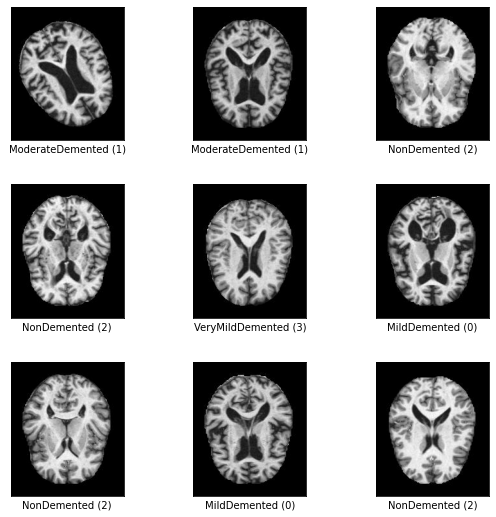

In [8]:
builder = tfds.folder_dataset.ImageFolder("drive/MyDrive/CV/Alzheimer_Dataset/")
print(builder.info)  
ds_info = builder.info
ds_train = builder.as_dataset(split='train2', shuffle_files=True, as_supervised=True)
ds_test = builder.as_dataset(split='test', shuffle_files=True, as_supervised=True)
fig = tfds.show_examples(ds_train, builder.info)

In [9]:
{ds_info.features['label'].str2int(x):x for x in ds_info.features['label'].names}

{0: 'MildDemented',
 1: 'ModerateDemented',
 2: 'NonDemented',
 3: 'VeryMildDemented'}

In [10]:
def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    # print(image)
    image = tf.cast(image, tf.float32) / 255.
    
    return 2*(image - 0.5), tf.one_hot(label, depth = 4)
    
ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
# ds_train = ds_train.shuffle(ds_info.splits['train[:5126]'].num_examples)
ds_train = ds_train.batch(BATCH_SIZE)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE)
# ds_train = ds_train.shuffle(ds_info.splits['train[:5126]'].num_examples)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

In [8]:
# Imbalanced data loss function
def focal_loss_custom(alpha, gamma):
    def binary_focal_loss(y_true, y_pred):
        fl = tfa.losses.SigmoidFocalCrossEntropy(alpha=alpha, gamma=gamma)
        y_true_K = tf.ones_like(y_true)
        focal_loss = fl(y_true, y_pred)
        return focal_loss
    return binary_focal_loss

Image size: 256 X 256
Patch size: 64 X 64
Patches per image: 16
Elements per patch: 12288


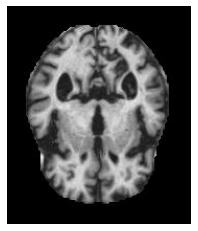

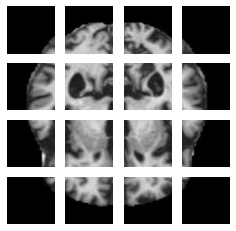

In [9]:
num_classes = 4
input_shape = (208, 176, 3)
image = cv2.imread("drive/MyDrive/CV/Alzheimer_Dataset/train2/ModerateDemented/moderateDem0.jpg")

learning_rate = 0.01
weight_decay = 0.0001
batch_size = 128
num_epochs = 100
image_size = 256
patch_size = 64  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 32
num_heads = 16
transformer_units = [
    projection_dim,
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 4
mlp_head_units = [512, 512]  # Size of the dense layers of the final classifier
mlp_head_units2 = [512, 256, 128, 32]

data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

plt.figure(figsize=(4, 4))
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [10]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.relu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    augmented = data_augmentation(inputs)
    patches = Patches(patch_size)(augmented)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    for idx in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1, name=f'multiheaded{idx}'
        )(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        encoded_patches = layers.Add(name=f"add{idx}")([x3, x2])

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    features = mlp(representation, hidden_units=mlp_head_units2, dropout_rate=0.2)
    logits = layers.Dense(num_classes, activation='softmax')(features)
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


model = create_vit_classifier()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 208, 176, 3  0           []                               
                                )]                                                                
                                                                                                  
 data_augmentation (Sequential)  (None, 256, 256, 3)  7          ['input_1[0][0]']                
                                                                                                  
 patches_1 (Patches)            (None, None, 12288)  0           ['data_augmentation[0][0]']      
                                                                                                  
 patch_encoder (PatchEncoder)   (None, 16, 32)       393760      ['patches_1[0][0]']          

In [11]:
learning_rate = 0.001
model = create_vit_classifier()
optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )
model.compile(
    optimizer=optimizer,
    loss=keras.losses.CategoricalCrossentropy(),#.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[keras.metrics.CategoricalAccuracy(name="Cat_accuracy")
        # keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
    ] 
)

# checkpoint_filepath = "/tmp/checkpoint"
# checkpoint_callback = keras.callbacks.ModelCheckpoint(
#     checkpoint_filepath,
#     monitor="val_accuracy",
#     save_best_only=True,
#     save_weights_only=True,
# )

history = model.fit(ds_train,
    batch_size=batch_size,
    epochs=250,
    verbose=2,
    validation_data=ds_test
    # callbacks=[checkpoint_callback],
)

# model.load_weights(checkpoint_filepath)
_, accuracy = model.evaluate(ds_test)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
model.save("/content/drive/MyDrive/CV/mymodel_vit")

Epoch 1/250
206/206 - 576s - loss: 1.2686 - Cat_accuracy: 0.4010 - val_loss: 1.0585 - val_Cat_accuracy: 0.5184 - 576s/epoch - 3s/step
Epoch 2/250
206/206 - 7s - loss: 1.1678 - Cat_accuracy: 0.4359 - val_loss: 1.0675 - val_Cat_accuracy: 0.5176 - 7s/epoch - 32ms/step
Epoch 3/250
206/206 - 6s - loss: 1.1016 - Cat_accuracy: 0.4651 - val_loss: 1.0472 - val_Cat_accuracy: 0.5207 - 6s/epoch - 31ms/step
Epoch 4/250
206/206 - 6s - loss: 1.0800 - Cat_accuracy: 0.4864 - val_loss: 1.0378 - val_Cat_accuracy: 0.4894 - 6s/epoch - 30ms/step
Epoch 5/250
206/206 - 6s - loss: 1.0706 - Cat_accuracy: 0.4804 - val_loss: 1.0645 - val_Cat_accuracy: 0.5152 - 6s/epoch - 30ms/step
Epoch 6/250
206/206 - 6s - loss: 1.0561 - Cat_accuracy: 0.4889 - val_loss: 1.0220 - val_Cat_accuracy: 0.4887 - 6s/epoch - 30ms/step
Epoch 7/250
206/206 - 6s - loss: 1.0581 - Cat_accuracy: 0.4843 - val_loss: 1.0156 - val_Cat_accuracy: 0.4840 - 6s/epoch - 30ms/step
Epoch 8/250
206/206 - 6s - loss: 1.0377 - Cat_accuracy: 0.4823 - val_loss:

INFO:tensorflow:Assets written to: /content/drive/MyDrive/CV/mymodel_vit/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/CV/mymodel_vit/assets


In [4]:
model = tf.keras.models.load_model("/content/drive/MyDrive/CV/mymodel_vit_")

# Check its architecture
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 208, 176, 3  0           []                               
                                )]                                                                
                                                                                                  
 data_augmentation (Sequential)  (None, 256, 256, 3)  7          ['input_2[0][0]']                
                                                                                                  
 patches_2 (Patches)            (None, None, 12288)  0           ['data_augmentation[0][0]']      
                                                                                                  
 patch_encoder_1 (PatchEncoder)  (None, 16, 32)      393760      ['patches_2[0][0]']        

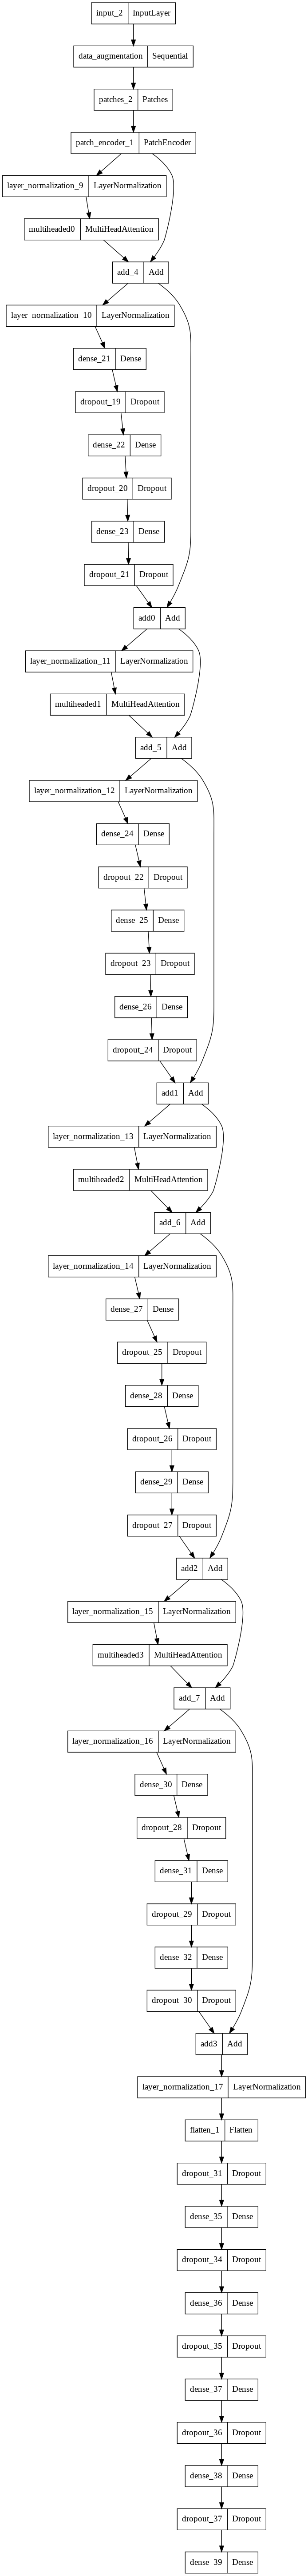

In [6]:
tf.keras.utils.plot_model(model)

In [31]:
image = cv2.imread("drive/MyDrive/CV/Alzheimer_Dataset/train2/ModerateDemented/moderateDem5.jpg")
# image = cv2.imread("/content/drive/MyDrive/CV/Alzheimer_Dataset/train2/NonDemented/nonDem0.jpg")
outputs = [
        l.output for l in model.layers if l.name in ['add0', 'add1', 'add2', 'add3', 'add4']
    ]
weights = np.array(
    tf.keras.models.Model(inputs=model.inputs, outputs=outputs).predict(np.expand_dims(image, axis=0))
)
num_layers = weights.shape[0]
num_heads = weights.shape[2]

In [32]:
mh = []
for idx,i in enumerate(model.layers):
    if "multiheaded" in i.name:
        mh.append(idx-1)
mh

[4, 15, 26, 37]

In [66]:
# Link used https://github.com/faustomorales/vit-keras/blob/65724adcfd3979067ce24734f08df0afa745637d/vit_keras/visualize.py#L7-L45
grid_size = 4

reshaped = weights.reshape(
        (num_layers, 32, grid_size , grid_size)
    )

reshaped = reshaped.mean(axis=1)
reshaped = reshaped + np.eye(reshaped.shape[1])
reshaped = reshaped / reshaped.sum(axis=(1, 2))[:, np.newaxis, np.newaxis]

v = reshaped[-1]
for n in range(1, len(reshaped)):
    v = np.matmul(v, reshaped[-1 - n])

# Attention from the output token to the input space.
mask = v#[0, 1:].reshape(grid_size, grid_size)
mask = cv2.resize(mask / mask.max(), (image.shape[1], image.shape[0]))[
    ..., np.newaxis
]
masked_img = (mask * image).astype("uint8")

Text(0.5, 1.0, 'Attention Image')

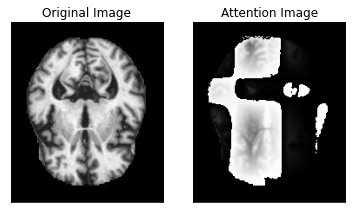

In [64]:
ax = plt.subplot(1, 2, 1)
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(image)
plt.title("Original Image")

ax = plt.subplot(1, 2, 2)
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(masked_img)
plt.title("Attention Image")